# Lab 5: Arithmetic and Number Representations
## Machine Learning Hardware Course

This notebook is Part 1 of the Arithmetic and Number Representations lab. It covers:
1. Environment setup
2. Quantize from FP32 to int8/6/4, FP16, BF16, FP8_E4M3, FP8_E5M2. Then present the result in bin, and reconstruct back to FP32.

## PART 1: ENVIRONMENT SETUP

First, we'll set up our environment by installing necessary libraries and checking available hardware.

Install specific versions of PyTorch, NumPy, and torchaudio/vision to ensure compatibility.
  
This ensures consistent results across different systems and environments

In [1]:
# Import necessary libraries
!pip uninstall -y torch torchaudio torchvision
!pip install torch==2.1.0 torchaudio==2.1.0 torchvision==0.16.0
!pip uninstall numpy -y
!pip install numpy==1.26.4

Found existing installation: torch 2.6.0+cu124
Uninstalling torch-2.6.0+cu124:
  Successfully uninstalled torch-2.6.0+cu124
Found existing installation: torchaudio 2.6.0+cu124
Uninstalling torchaudio-2.6.0+cu124:
  Successfully uninstalled torchaudio-2.6.0+cu124
Found existing installation: torchvision 0.21.0+cu124
Uninstalling torchvision-0.21.0+cu124:
  Successfully uninstalled torchvision-0.21.0+cu124
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 76.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 92.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 98.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 82.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 48.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## Check the version of numpy and pytorch

Check the versions of installed libraries and GPU availability.  
Verifies that the correct software stack and hardware resources are ready

In [1]:
import torch
import numpy as np
import torch.quantization as quant

# Check Numpy, Pytorch version and available hardware
print("Numpy version:", np.__version__)
print("Pytorch version:", torch.__version__)
print("CUDA version:", torch.version.cuda)
print("GPU available:", torch.cuda.is_available())


Numpy version: 1.26.4
Pytorch version: 2.1.0+cu121
CUDA version: 12.1
GPU available: False


It should show as below.  
```
Numpy version: 1.26.4.     
Pytorch version: 2.1.0+cu121.     
CUDA version: 12.1.    
GPU available: False
```

If numpy version is 2.0.2 instead of 1.26.4, click Runtime->Restart session and re-run the Version checking block.


In [2]:
!pip install git+https://github.com/liuhao-97/microxcaling.git

  Cloning https://github.com/liuhao-97/microxcaling.git to /tmp/pip-req-build-2i6qr7ga
  Running command git clone --filter=blob:none --quiet https://github.com/liuhao-97/microxcaling.git /tmp/pip-req-build-2i6qr7ga
  Resolved https://github.com/liuhao-97/microxcaling.git to commit 022dba61804ec2e20b3beb2957634fb0b8f8682f
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for mx: filename=mx-0.1.dev35+g022dba6-py3-none-any.whl size=102573 sha256=03f5cc1c109b5d859f82c7f692b85789a628bbc9ec62475ba0147051c6b672d2
  Stored in directory: /tmp/pip-ephem-wheel-cache-6oskh3q9/wheels/c9/83/69/dd08d1d253c03b3b61554607128440954fdacad156454d983d
Successfully built mx


### Quantize from FP32 to int8, int6, int4

Define functions to quantize float32 to int8, int6, int4 and reconstruct back.  
Includes MSE computation and bit-level binary formatting.  


#### Takeaway: Shows the effect of reducing precision on numeric accuracy.  

In [11]:
import numpy as np

# Quantizes a float32 numpy array `x` into integer values using uniform quantization
# with the specified bit-width. Returns the quantized values and the scale used.
def quantize(x, bits):
    if bits < 2:
        raise ValueError("Bits must be >= 2")
    qmax = 2**(bits - 1) - 1
    qmin = -2**(bits - 1)
    max_abs = np.max(np.abs(x))
    scale = max_abs / qmax if max_abs > 0 else 1e-10 # Avoid division by zero
    q = np.round(x / scale).astype(int) # Quantize: scale and round
    q = np.clip(q, qmin, qmax)
    return q, scale

# Reconstructs approximate float32 values from quantized integers using the scale
def dequantize(q, scale):
    return q * scale

# Converts a signed integer `x` into a binary string of length `bits`, two's complement format
def int_to_bin(x, bits):
    qmin = -2**(bits - 1)
    qmax = 2**(bits - 1) - 1
    x = np.clip(x, qmin, qmax)
    if x < 0:
        x = (1 << bits) + x
    return format(x, f'0{bits}b')

# Example float32 values
fp32_values = np.array([-0.3006, -12.2760,   0.7851,   6.6808,  -2.2207,   0.9973, -10.8371,
          13.1378,   1.3044,   5.2754], dtype=np.float32)

# Quantize and evaluate using different bit-widths
for bits in [8, 6, 4,]:
    print(f"\n==== Quantizing to INT{bits} ====")
    q_vals, scale = quantize(fp32_values, bits)
    dq_vals = dequantize(q_vals, scale)
    mse = np.mean((fp32_values - dq_vals) ** 2)
    mae = np.mean(np.abs(fp32_values - dq_vals))
    print(f"{'FP32':>10} {'INT':>6} {'BINARY':>{bits+2}} {'DEQUANT_FP32':>15}")
    for f, q, dq in zip(fp32_values, q_vals, dq_vals):
        binary = int_to_bin(q, bits)
        print(f"{f:10.4f} {q:6} {binary:>{bits+2}} {dq:15.4f}")
    # Print error metrics
    print(f"Quantization MAE: {mae:.6f}")
    print(f"\nQuantization MSE: {mse:.6f}")


==== Quantizing to INT8 ====
      FP32    INT     BINARY    DEQUANT_FP32
   -0.3006     -3   11111101         -0.3103
  -12.2760   -119   10001001        -12.3102
    0.7851      8   00001000          0.8276
    6.6808     65   01000001          6.7241
   -2.2207    -21   11101011         -2.1724
    0.9973     10   00001010          1.0345
  -10.8371   -105   10010111        -10.8620
   13.1378    127   01111111         13.1378
    1.3044     13   00001101          1.3448
    5.2754     51   00110011          5.2758
Quantization MAE: 0.028088

Quantization MSE: 0.001091

==== Quantizing to INT6 ====
      FP32    INT   BINARY    DEQUANT_FP32
   -0.3006     -1   111111         -0.4238
  -12.2760    -29   100011        -12.2902
    0.7851      2   000010          0.8476
    6.6808     16   010000          6.7808
   -2.2207     -5   111011         -2.1190
    0.9973      2   000010          0.8476
  -10.8371    -26   100110        -11.0188
   13.1378     31   011111         13.1378
   

### Quantize from FP32 to FP16, BF16, FP8_E4M3, FP8_E5M2

Utility functions for converting between FP32 and various formats (FP16, BF16, FP8)     
Takeaway: Understand IEEE754-style bit representations for reduced-precision floats

In [4]:
import numpy as np
import struct

# ==== Utility Functions to Convert Between Float and Bit Representations ====

# Convert float32 to 32-bit integer representation
def float32_to_bits(f):
    return struct.unpack('>I', struct.pack('>f', f))[0]

# Convert 32-bit integer bits back to float32
def bits_to_float32(b):
    return struct.unpack('>f', struct.pack('>I', b))[0]

# Convert float32 to IEEE 754 half-precision (fp16) 16-bit binary
def float32_to_fp16(f):
    return np.float16(f).view(np.uint16)

# Convert fp16 binary back to float32
def fp16_to_float32(bits):
    return np.float16(bits.view(np.float16)).astype(np.float32)

# Convert float32 to bfloat16 (high 16 bits of float32)
def float32_to_bf16(f):
    bits = float32_to_bits(f)
    return bits >> 16

# Convert bfloat16 (high 16 bits) back to float32
def bf16_to_float32(bf16_bits):
    return bits_to_float32(bf16_bits << 16)

# ==== Manual FP8 Conversions ====

# Convert float32 to FP8 E4M3 (1 sign bit, 4 exponent bits, 3 mantissa bits)
def float32_to_fp8_e4m3(f):
    f_bits = float32_to_bits(f)
    sign = (f_bits >> 31) & 0x1
    exponent = (f_bits >> 23) & 0xFF
    mantissa = f_bits & 0x7FFFFF

    fp32_bias = 127
    fp8_bias = 7
    exp_unbiased = exponent - fp32_bias + fp8_bias

    if exponent == 0 or exp_unbiased <= 0:
        return sign << 7  # zero
    elif exp_unbiased >= 0b1111:
        return (sign << 7) | (0b1111 << 3)  # inf/nan
    else:
        mant = mantissa >> (23 - 3)
        return (sign << 7) | (exp_unbiased << 3) | (mant & 0b111)

# Convert FP8 E4M3 8-bit value back to float32
def fp8_e4m3_to_float32(fp8):
    sign = (fp8 >> 7) & 0x1
    exponent = (fp8 >> 3) & 0xF
    mantissa = fp8 & 0b111

    if exponent == 0 and mantissa == 0:
        return -0.0 if sign else 0.0
    elif exponent == 0b1111:
        return float('-inf') if sign else float('inf')

    fp8_bias = 7
    fp32_bias = 127
    exp = exponent - fp8_bias + fp32_bias
    mant = mantissa << (23 - 3)
    bits = (sign << 31) | (exp << 23) | mant
    return bits_to_float32(bits)

# Convert float32 to FP8 E5M2 (1 sign bit, 5 exponent bits, 2 mantissa bits)
def float32_to_fp8_e5m2(f):
    f_bits = float32_to_bits(f)
    sign = (f_bits >> 31) & 0x1
    exponent = (f_bits >> 23) & 0xFF
    mantissa = f_bits & 0x7FFFFF

    fp32_bias = 127
    fp8_bias = 15
    exp_unbiased = exponent - fp32_bias + fp8_bias

    if exponent == 0 or exp_unbiased <= 0:
        return sign << 7  # zero
    elif exp_unbiased >= 0b11111:
        return (sign << 7) | (0b11111 << 2)  # inf/nan
    else:
        mant = mantissa >> (23 - 2)
        return (sign << 7) | (exp_unbiased << 2) | (mant & 0b11)

# Convert FP8 E5M2 8-bit value back to float32
def fp8_e5m2_to_float32(fp8):
    sign = (fp8 >> 7) & 0x1
    exponent = (fp8 >> 2) & 0x1F
    mantissa = fp8 & 0b11

    if exponent == 0 and mantissa == 0:
        return -0.0 if sign else 0.0
    elif exponent == 0b11111:
        return float('-inf') if sign else float('inf')

    fp8_bias = 15
    fp32_bias = 127
    exp = exponent - fp8_bias + fp32_bias
    mant = mantissa << (23 - 2)
    bits = (sign << 31) | (exp << 23) | mant
    return bits_to_float32(bits)



### Run the conversion on sample FP32 values
Run the conversion on sample FP32 values and display their bit-level layout. Helpful for visualizing how exponent and mantissa bits change across formats

In [5]:
# Sample values
# ==== Run Example on Sample Float Values ====
values = [-0.3006, -12.2760,   0.7851,   6.6808,  -2.2207,   0.9973, -10.8371,
          13.1378,   1.3044,   5.2754]

# Print original and quantized bit representations
# Print header
print(f"{'Value':>8} | {'FP32 (S|E|M)':>32} | {'FP16 (S|E|M)':>20} | {'BF16 (S|E|M)':>20} | {'FP8-E4M3 (S|E|M)':>20} | {'FP8-E5M2 (S|E|M)':>20}")
print("-"*120)
for val in values:
    fp32_bits = float32_to_bits(val)
    fp16_bits = float32_to_fp16(val)
    bf16_bits = float32_to_bf16(val)
    fp8_e4m3 = float32_to_fp8_e4m3(val)
    fp8_e5m2 = float32_to_fp8_e5m2(val)

    # Extract sign, exponent, mantissa bits
    fp32_s = (fp32_bits >> 31) & 0x1
    fp32_e = (fp32_bits >> 23) & 0xFF
    fp32_m = fp32_bits & 0x7FFFFF

    fp16_s = (fp16_bits >> 15) & 0x1
    fp16_e = (fp16_bits >> 10) & 0x1F
    fp16_m = fp16_bits & 0x3FF

    bf16_s = (bf16_bits >> 15) & 0x1
    bf16_e = (bf16_bits >> 7) & 0xFF
    bf16_m = bf16_bits & 0x7F

    fp8_4_s = (fp8_e4m3 >> 7) & 0x1
    fp8_4_e = (fp8_e4m3 >> 3) & 0xF
    fp8_4_m = fp8_e4m3 & 0x7

    fp8_5_s = (fp8_e5m2 >> 7) & 0x1
    fp8_5_e = (fp8_e5m2 >> 2) & 0x1F
    fp8_5_m = fp8_e5m2 & 0x3

    print(f"{val:8.4f} | "
          f"{fp32_s:1b} {fp32_e:08b} {fp32_m:023b} | "
          f"{fp16_s:1b} {fp16_e:05b} {fp16_m:010b} | "
          f"{bf16_s:1b} {bf16_e:08b} {bf16_m:07b} | "
          f"{fp8_4_s:1b} {fp8_4_e:04b} {fp8_4_m:03b}       | "
          f"{fp8_5_s:1b} {fp8_5_e:05b} {fp8_5_m:02b}")

   Value |                     FP32 (S|E|M) |         FP16 (S|E|M) |         BF16 (S|E|M) |     FP8-E4M3 (S|E|M) |     FP8-E5M2 (S|E|M)
------------------------------------------------------------------------------------------------------------------------
 -0.3006 | 1 01111101 00110011110100000111110 | 1 01101 0011001111 | 1 01111101 0011001 | 1 0101 001       | 1 01101 00
-12.2760 | 1 10000010 10001000110101001111111 | 1 10010 1000100011 | 1 10000010 1000100 | 1 1010 100       | 1 10010 10
  0.7851 | 0 01111110 10010001111110001010000 | 0 01110 1001001000 | 0 01111110 1001000 | 0 0110 100       | 0 01110 10
  6.6808 | 0 10000001 10101011100100100011101 | 0 10001 1010101110 | 0 10000001 1010101 | 0 1001 101       | 0 10001 10
 -2.2207 | 1 10000000 00011100001111111110011 | 1 10000 0001110001 | 1 10000000 0001110 | 1 1000 000       | 1 10000 00
  0.9973 | 0 01111110 11111110100111100001110 | 0 01110 1111111010 | 0 01111110 1111111 | 0 0110 111       | 0 01110 11
-10.8371 | 1 10000010 0

### Convert reduced-precision values back to FP32
Convert reduced-precision values back to FP32 and compare them
Takeaway: Observe how rounding and truncation impact numerical accuracy

In [8]:
# Print reconstruction results and compute average error
print("\nReconstruction to FP32:")
print(f"{'Value':>8} | {'From FP16':>10} | {'From BF16':>10} | {'From FP8_E4M3':>10} | {'From FP8_E5M2':>10}")
print("-"*60)

# Track total errors
err_fp16 = 0
err_bf16 = 0
err_e4m3 = 0
err_e5m2 = 0

for val in values:
    fp16_bits = float32_to_fp16(val)
    bf16_bits = float32_to_bf16(val)
    fp8_e4m3 = float32_to_fp8_e4m3(val)
    fp8_e5m2 = float32_to_fp8_e5m2(val)

    f_fp16 = fp16_to_float32(fp16_bits)
    f_bf16 = bf16_to_float32(bf16_bits)
    f_e4m3 = fp8_e4m3_to_float32(fp8_e4m3)
    f_e5m2 = fp8_e5m2_to_float32(fp8_e5m2)

    # Print reconstruction
    print(f"{val:8.4f} | {f_fp16:10.4f} | {f_bf16:10.4f} | {f_e4m3:10.4f} | {f_e5m2:10.4f}")

    # Accumulate absolute errors
    err_fp16 += abs(val - f_fp16)
    err_bf16 += abs(val - f_bf16)
    err_e4m3 += abs(val - f_e4m3)
    err_e5m2 += abs(val - f_e5m2)

# Compute averages
n = len(values)
print("\nAverage Absolute Errors:")
print(f"{'FP16':>10}: {err_fp16 / n:.6f}")
print(f"{'BF16':>10}: {err_bf16 / n:.6f}")
print(f"{'FP8-E4M3':>10}: {err_e4m3 / n:.6f}")
print(f"{'FP8-E5M2':>10}: {err_e5m2 / n:.6f}")


Reconstruction to FP32:
   Value |  From FP16 |  From BF16 | From FP8_E4M3 | From FP8_E5M2
------------------------------------------------------------
 -0.3006 |    -0.3005 |    -0.2988 |    -0.2812 |    -0.2500
-12.2760 |   -12.2734 |   -12.2500 |   -12.0000 |   -12.0000
  0.7851 |     0.7852 |     0.7812 |     0.7500 |     0.7500
  6.6808 |     6.6797 |     6.6562 |     6.5000 |     6.0000
 -2.2207 |    -2.2207 |    -2.2188 |    -2.0000 |    -2.0000
  0.9973 |     0.9971 |     0.9961 |     0.9375 |     0.8750
-10.8371 |   -10.8359 |   -10.8125 |   -10.0000 |   -10.0000
 13.1378 |    13.1406 |    13.1250 |    13.0000 |    12.0000
  1.3044 |     1.3047 |     1.2969 |     1.2500 |     1.2500
  5.2754 |     5.2773 |     5.2500 |     5.0000 |     5.0000

Average Absolute Errors:
      FP16: 0.001025
      BF16: 0.012965
  FP8-E4M3: 0.209645
  FP8-E5M2: 0.369020


## PART 2: Exploring Microscaling (MX) data formats for DNN

This notebook is Part 2 of the Arithmetic and Number Representations lab.

1. Train a Simple MNIST Linear Model and obtain the original accuracy.
2. Quantize and evaluate the output matrix with different MX data formats.
3. Quantize and evaluate the matrix multiplication accumulation with different MX data formats.
4. Evaluate quantized DNN with different MX data formats.



### Train a Simple MNIST Linear Model and obtain the original accuracy.

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. Load and preprocess MNIST
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # MNIST mean and std
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# 2. Define the model
class LinearModel(nn.Module):
    def __init__(self):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(28 * 28, 10,bias=True)  # 784 inputs (flattened 28x28), 10 outputs

    def forward(self, x):
        x = x.view(-1, 28 * 28)  # Flatten the 28x28 images
        return self.linear(x)

model = LinearModel().to(device)

# 3. Set loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# 4. Train the model
def train_model(num_epochs=5):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Zero gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

# 5. Evaluate the model
def test_model():
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")

# Run training and testing
train_model(num_epochs=5)
test_model()

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9912422/9912422 [00:00<00:00, 54264554.91it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28881/28881 [00:00<00:00, 1705608.03it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1648877/1648877 [00:00<00:00, 12721922.29it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4542/4542 [00:00<00:00, 7372495.65it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Epoch [1/5], Loss: 0.3598
Epoch [2/5], Loss: 0.3098
Epoch [3/5], Loss: 0.2958
Epoch [4/5], Loss: 0.2923
Epoch [5/5], Loss: 0.2866
Test Accuracy: 91.47%


In [14]:
model.eval()  # Set model to evaluation mode
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

with torch.no_grad():
    for i, (images, labels) in enumerate(test_loader):
      if i>=1:
        break
      images, labels = images.to(device), labels.to(device)
      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)
      print(f"Sample {i+1}:")
      print("Label:", labels)
      print("Outputs:", outputs)
      print("Predicted:", predicted)
      print(" ")

Sample 1:
Label: tensor([7])
Outputs: tensor([[ 2.0779e-01, -1.3379e+01, -1.2669e-01,  8.2287e+00, -2.3440e+00,
          2.7798e-01, -1.2317e+01,  1.2790e+01, -5.6383e-03,  3.6770e+00]])
Predicted: tensor([7])
 


In [16]:
# Assuming `model` is the trained LinearModel from the previous code
model.eval()  # Set model to evaluation mode

# 1. Extract weight matrix and bias
weight_matrix = model.linear.weight  # Shape: (10, 784)
bias_vector = model.linear.bias      # Shape: (10,)

# 2. Convert to NumPy (optional)
weight_matrix_np = weight_matrix.detach().cpu().numpy()  # Convert to NumPy array
bias_vector_np = bias_vector.detach().cpu().numpy()      # Convert to NumPy array
# 3. Print shapes and example values
print("Weight matrix shape:", weight_matrix.shape)
print("Bias vector shape:", bias_vector.shape)
print("First row of weight matrix (weights for class 0):\n", weight_matrix_np[0, :10])  # First 10 weights for class 0
print("Bias vector:\n", bias_vector_np)
print(" ")

# Process first samples
with torch.no_grad():
    for i, (images, labels) in enumerate(test_loader):
        if i >= 1:
            break
        images, labels = images.to(device), labels.to(device)

        # Flatten images for torch.nn.functional.linear
        images_flat = images.view(-1, 28*28)  # Shape: (1, 784)

        # Compute output using torch.nn.functional.linear
        outputs = torch.nn.functional.linear(input=images_flat, weight=weight_matrix, bias=bias_vector)

        # Get predicted class
        _, predicted = torch.max(outputs.data, 1)

        # Print results in the same format as the second code
        print(f"Sample {i+1}:")
        print("Label:", labels)
        print("Outputs:", outputs)
        print("Predicted:", predicted)
        print(" ")

Weight matrix shape: torch.Size([10, 784])
Bias vector shape: torch.Size([10])
First row of weight matrix (weights for class 0):
 [ 0.03753845  0.02827165  0.03180858  0.01949433 -0.02233827 -0.00849613
 -0.00610361  0.01507413  0.00635218  0.02939069]
Bias vector:
 [-0.03349502 -0.04565147  0.0503958   0.05765447 -0.1092443   0.11897562
 -0.00933663  0.00247599  0.02028898 -0.04327393]
 
Sample 1:
Label: tensor([7])
Outputs: tensor([[ 2.0779e-01, -1.3379e+01, -1.2669e-01,  8.2287e+00, -2.3440e+00,
          2.7798e-01, -1.2317e+01,  1.2790e+01, -5.6383e-03,  3.6770e+00]])
Predicted: tensor([7])
 



### Quantize and evaluate the output matrix with different MX data formats.

In [17]:
import mx
from mx import mx_mapping, MxSpecs, linear, matmul, Linear
from mx.specs import finalize_mx_specs
from mx.elemwise_ops import _quantize_bfloat
from mx.formats import _get_format_params
from mx.mx_ops import _quantize_mx, quantize_mx_op
import pytest
import torch
import numpy as np
import sys
import matplotlib.pyplot as plt

In [19]:
# Set random seed for reproducibility
np.random.seed(43)
torch.manual_seed(43)

for i, (images, labels) in enumerate(test_loader):
    if i == 0:
      images, labels = images.to(device), labels.to(device)
      # Flatten images for torch.nn.functional.linear
      images_flat = images.view(-1, 28*28)  # Shape: (1, 784)
      A = images_flat.detach().cpu().numpy()  # Shape: (1, 784)
      break

# print(A.shape)
B = weight_matrix_np
C = bias_vector_np

# print(B.shape) # Shape:(10, 784)
# print(C.shape) # Shape:(10,)

# Convert to PyTorch tensors
A_torch = torch.from_numpy(A) # Shape: (1, 784)
B_torch = torch.from_numpy(B) # Shape:(10, 784)
C_torch = torch.from_numpy(C) # Shape:(10,)

# Ground truth with NumPy (FP32)
with torch.no_grad():
  D_torch = torch.nn.functional.linear(input=images_flat, weight=weight_matrix, bias=bias_vector)
D_ground_truth = D_torch.detach().cpu().numpy()
print("D_ground_truth: \n",D_ground_truth)
print("D_torch: \n",D_ground_truth)

_, predicted = torch.max(D_torch.data, 1)
print("Label:", labels)
print("Outputs:", outputs)
print("Predicted:", predicted)

D_ground_truth: 
 [[ 2.07787797e-01 -1.33789425e+01 -1.26686200e-01  8.22873974e+00
  -2.34404802e+00  2.77983606e-01 -1.23166294e+01  1.27899275e+01
  -5.63826971e-03  3.67698860e+00]]
D_torch: 
 [[ 2.07787797e-01 -1.33789425e+01 -1.26686200e-01  8.22873974e+00
  -2.34404802e+00  2.77983606e-01 -1.23166294e+01  1.27899275e+01
  -5.63826971e-03  3.67698860e+00]]
Label: tensor([7])
Outputs: tensor([[ 2.0779e-01, -1.3379e+01, -1.2669e-01,  8.2287e+00, -2.3440e+00,
          2.7798e-01, -1.2317e+01,  1.2790e+01, -5.6383e-03,  3.6770e+00]])
Predicted: tensor([7])


### Quantize and evaluate the output matrix with different MX data formats.

Quantization Error Metrics:
Method                MAE          MSE
------------------------------------
mx_int8 Truth Label: tensor([7]), Predicted: tensor([7])
mxint8             0.024248     0.000914

mx_int4 Truth Label: tensor([7]), Predicted: tensor([7])
mxint4             0.309549     0.144850

mx_int2 Truth Label: tensor([7]), Predicted: tensor([3])
mxint2             1.935337     7.900542

mx_fp8_e5m2 Truth Label: tensor([7]), Predicted: tensor([7])
mxfp8_e5m2         0.233015     0.121883

mx_fp8_e4m3 Truth Label: tensor([7]), Predicted: tensor([7])
mxfp8_e4m3         0.141526     0.038051

mx_fp6_e3m2 Truth Label: tensor([7]), Predicted: tensor([7])
mxfp6_e3m2         0.233210     0.121883

mx_fp6_e2m3 Truth Label: tensor([7]), Predicted: tensor([7])
mxfp6_e2m3         0.150059     0.037228

mx_fp4_e2m1 Truth Label: tensor([7]), Predicted: tensor([7])
mxfp4_e2m1         0.435337     0.339126

mx_fp16 Truth Label: tensor([7]), Predicted: tensor([7])
mxfp16             0.001178

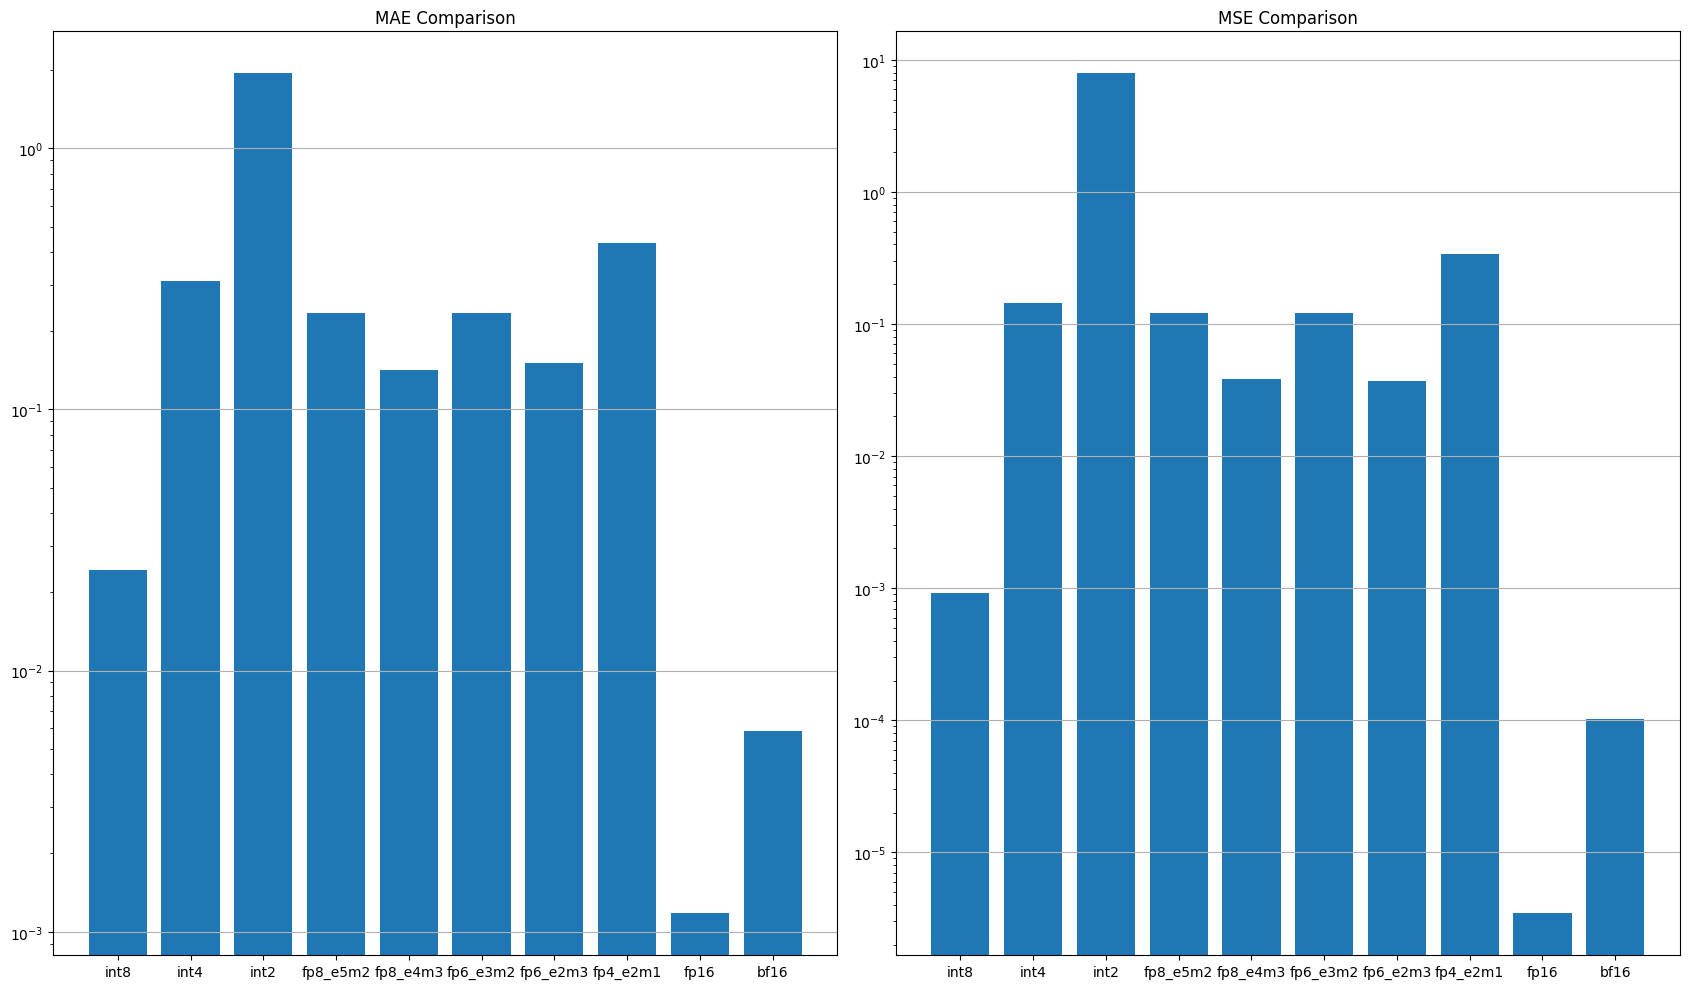

In [23]:
quant_list = ['int8', 'int4', 'int2', 'fp8_e5m2', 'fp8_e4m3', 'fp6_e3m2', 'fp6_e2m3', 'fp4_e2m1', 'fp16', 'bf16']
mae_list = []
mse_list = []

print("Quantization Error Metrics:")
print(f"{'Method':<12} {'MAE':>12} {'MSE':>12}")
print("-" * 36)

for quant_method in quant_list:
    D_mx = _quantize_mx(D_torch, 8, quant_method,
                        block_size=8,
                        axes=[-1],
                        round='nearest',
                        flush_fp32_subnorms=False,
                        custom_cuda=False)

    _, mx_predicted = torch.max(D_mx.data, 1)
    print(f"mx_{quant_method} Truth Label: {labels}, Predicted: {mx_predicted}")

    mae = torch.mean(torch.abs(D_mx - D_torch)).item()
    mse = torch.mean((D_mx - D_torch) ** 2).item()

    mae_list.append(mae)
    mse_list.append(mse)

    print(f"mx{quant_method:<12} {mae:12.6f} {mse:12.6f}")
    print()

# Visualize the metrics
plt.figure(figsize=(17, 10))

# MAE
plt.subplot(1, 2, 1)
plt.bar(quant_list, mae_list)
plt.title('MAE Comparison')
plt.grid(axis='y')
plt.yscale('log')

# MSE
plt.subplot(1, 2, 2)
plt.bar(quant_list, mse_list)
plt.title('MSE Comparison')
plt.grid(axis='y')
plt.yscale('log')

plt.tight_layout()
plt.show()

### Compare MX_int8 with int8 matrix.

mxint8 Truth Label: tensor([7]), Predicted: tensor([7])
D_mxint8:
 tensor([[  0.2500, -13.3750,  -0.1250,   8.2500,  -2.3750,   0.2500, -12.3750,
          12.7500,  -0.0000,   3.6875]])


MAE_mxint8:  tensor(0.0242)
MSE_mxint8:  tensor(0.0009)
int8 Truth Label: tensor([7]), Predicted: tensor([7])
D_int8:
 tensor([[  0, -13,   0,   8,  -2,   0, -12,  12,   0,   3]], dtype=torch.int8)


MAE_int8:  tensor(0.3353)
MSE_int8:  tensor(0.1633)


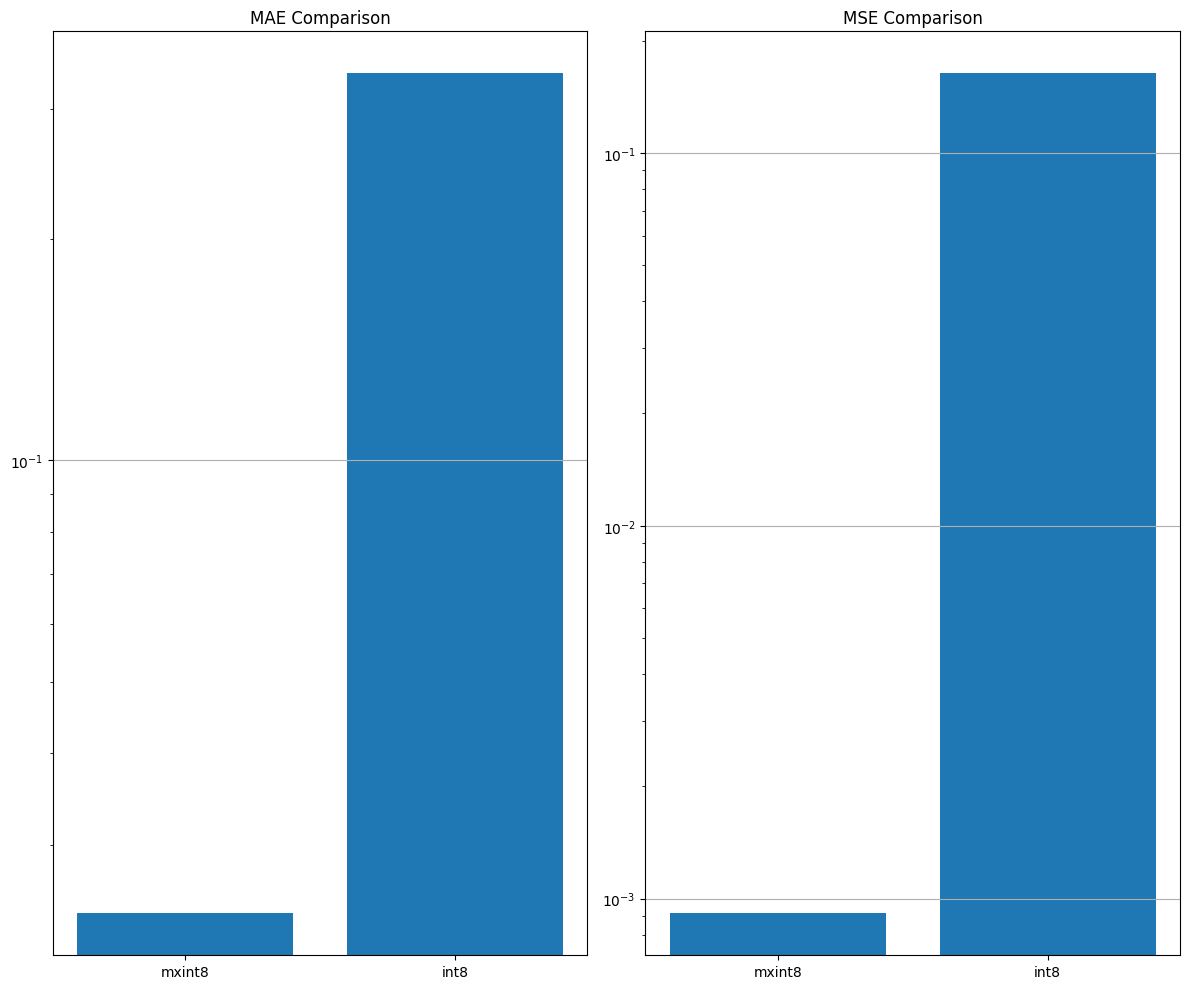

In [24]:
D_mxint8 = _quantize_mx(D_torch, 8, 'int8',
                block_size=8,
                axes=[-1],
                round='nearest',
                flush_fp32_subnorms=False,
                custom_cuda=False)

_, mxint8_predicted = torch.max(D_mxint8.data, 1)
print(f"mxint8 Truth Label: {labels}, Predicted: {mxint8_predicted}")
print("D_mxint8:\n", D_mxint8 )
print("\n")


mae_mxint8=torch.mean(torch.abs(D_mxint8 - D_torch))
mse_mxint8=torch.mean((D_mxint8 - D_torch) ** 2)
print("MAE_mxint8: ",mae_mxint8)
print("MSE_mxint8: ",mse_mxint8)




D_int8 = D_torch.type(torch.int8)
_, int8_predicted = torch.max(D_mxint8.data, 1)
print(f"int8 Truth Label: {labels}, Predicted: {int8_predicted}")
print("D_int8:\n", D_int8)
print("\n")


mae_int8=torch.mean(torch.abs(D_int8 - D_torch))
mse_int8=torch.mean((D_int8 - D_torch) ** 2)
print("MAE_int8: ", mae_int8)
print("MSE_int8: ", mse_int8)


# Visualize the metrics
plt.figure(figsize=(12, 10))

# MAE
plt.subplot(1, 2, 1)
plt.bar(['mxint8', 'int8'],[mae_mxint8,mae_int8])
plt.title('MAE Comparison')
plt.grid(axis='y')
plt.yscale('log')

# Training time comparison
plt.subplot(1, 2, 2)
plt.bar(['mxint8', 'int8'],[mse_mxint8,mse_int8])
plt.title('MSE Comparison')
plt.grid(axis='y')
plt.yscale('log')

plt.tight_layout()
plt.show()

### Test MX_int8 for various block sizes
Plot and analyze how error trends vary with block size

mxint8 blocksize: 1, Truth Label: tensor([7]), Predicted: tensor([7])


blocksize 1: 
MAE: 0.01359966117888689
MSE: 0.000558050349354744

mxint8 blocksize: 2, Truth Label: tensor([7]), Predicted: tensor([7])


blocksize 2: 
MAE: 0.018711332231760025
MSE: 0.0007406622753478587

mxint8 blocksize: 3, Truth Label: tensor([7]), Predicted: tensor([7])


blocksize 3: 
MAE: 0.02424844726920128
MSE: 0.0009136971202678978

mxint8 blocksize: 4, Truth Label: tensor([7]), Predicted: tensor([7])


blocksize 4: 
MAE: 0.02424844726920128
MSE: 0.0009136971202678978

mxint8 blocksize: 6, Truth Label: tensor([7]), Predicted: tensor([7])


blocksize 6: 
MAE: 0.02839616872370243
MSE: 0.0011729297693818808

mxint8 blocksize: 7, Truth Label: tensor([7]), Predicted: tensor([7])


blocksize 7: 
MAE: 0.02839616872370243
MSE: 0.0011729297693818808

mxint8 blocksize: 8, Truth Label: tensor([7]), Predicted: tensor([7])


blocksize 8: 
MAE: 0.02424844726920128
MSE: 0.0009136971202678978

mxint8 blocksize: 9, Truth 

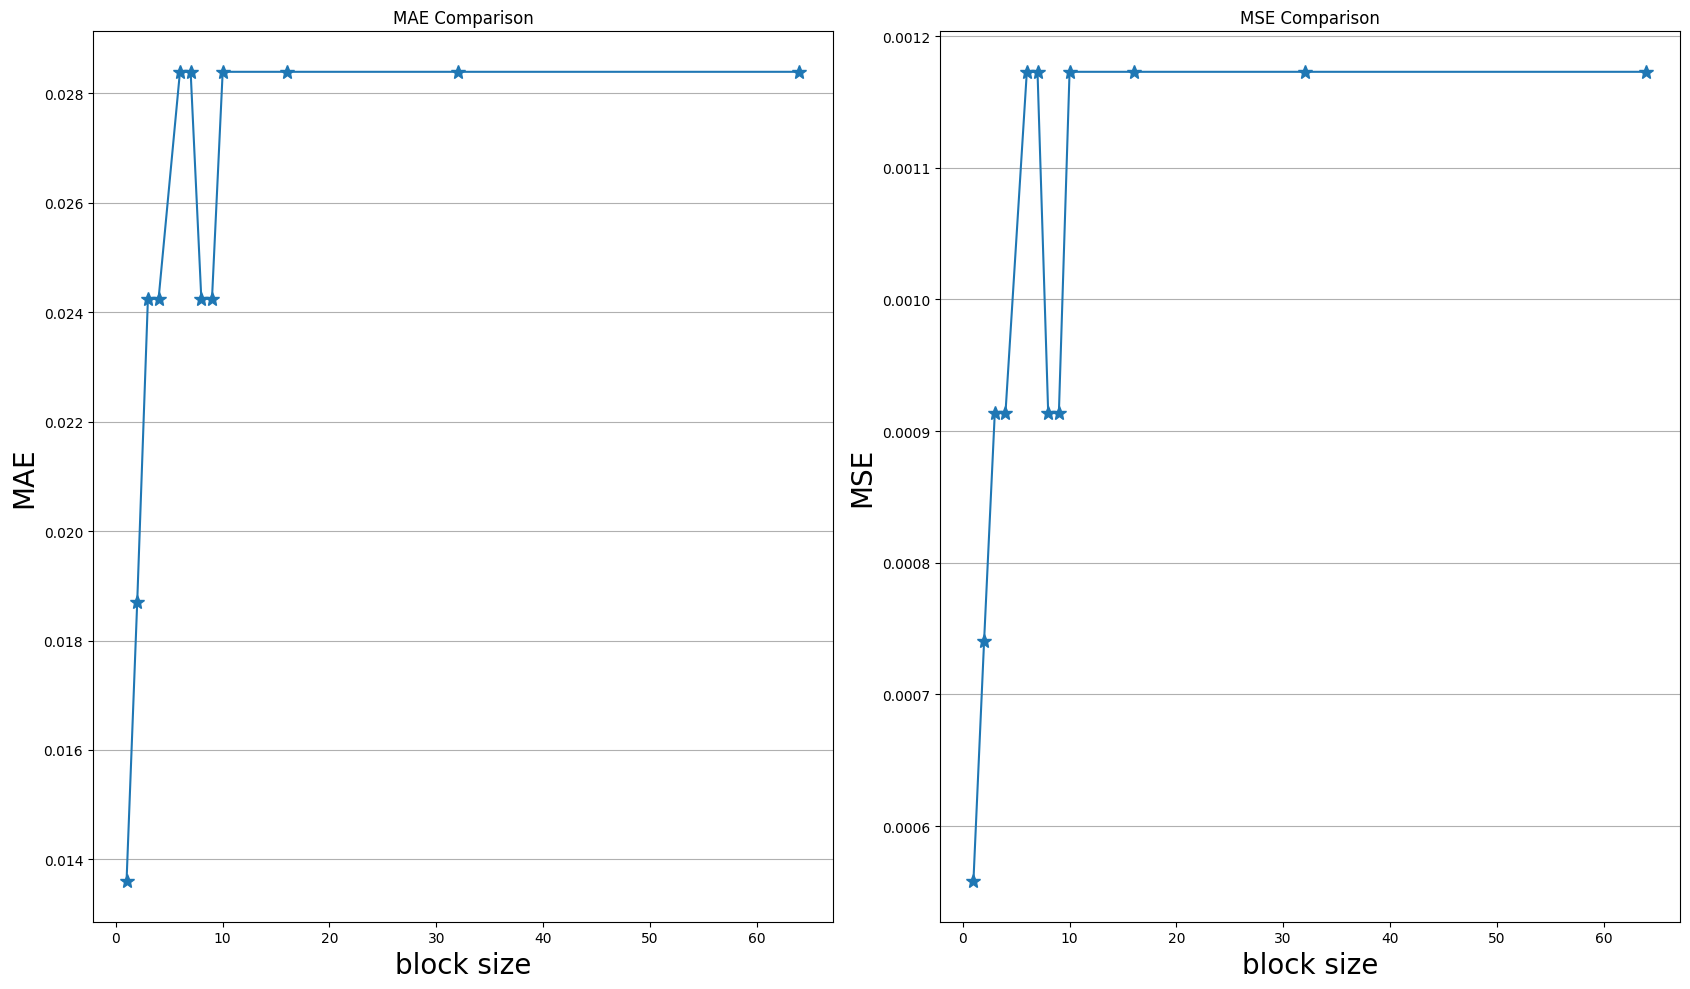

In [36]:
blocksize_list = [1,2,3,4,6,7,8,9,10,]
mae_list = []
mse_list = []

for blocksize in blocksize_list:
  D_mx = _quantize_mx(D_torch, 32, 'int8',
                  block_size=blocksize,
                  axes=[-1],
                  round='nearest',
                  flush_fp32_subnorms=False,
                  custom_cuda=False)
  _, mx_predicted = torch.max(D_mx.data, 1)
  print(f"mxint8 blocksize: {blocksize}, Truth Label: {labels}, Predicted: {mx_predicted}")
  # print("D_mx:\n", D_mx)
  print("\n")

  mae_list.append(torch.mean(torch.abs(D_mx - D_torch)))
  mse_list.append(torch.mean((D_mx - D_torch) ** 2))
  print(f"blocksize {blocksize}: ")
  print(f"MAE: {torch.mean(torch.abs(D_mx - D_torch))}")
  print(f"MSE: {torch.mean((D_mx - D_torch) ** 2)}\n")

# Visualize the metrics
plt.figure(figsize=(17, 10))

# MAE
plt.subplot(1, 2, 1)
plt.plot(blocksize_list,mae_list,markersize=10, marker='*')
plt.xlabel('block size', size=20)
plt.ylabel('MAE', size=20)
plt.title('MAE Comparison')
# plt.ylim(0.06, 0.067)  # Adjust as needed
plt.grid(axis='y')

# Training time comparison
plt.subplot(1, 2, 2)
plt.plot(blocksize_list,mse_list,markersize=10, marker='*')
plt.title('MSE Comparison')
plt.xlabel('block size', size=20)
plt.ylabel('MSE', size=20)
# plt.ylim(0.005, 0.0062)  # Adjust as needed
plt.grid(axis='y')

plt.tight_layout()
plt.show()

In [37]:
# Define helper function for matrix multiplication accumulation
def matmul_accumulate(A, B, C, mx_specs=None):
    if mx_specs is None:
        # Native PyTorch FP32
        # return torch.matmul(A, B) + C
        return torch.nn.functional.linear(A, B, C)
    else:
        # Use microxcaling's linear function for quantized computation
        return mx.linear(A, B, C, mx_specs=mx_specs)

# Compute accuracy metrics
def compute_errors(ground_truth, result):
    result_np = result.cpu().numpy()  # Move back to CPU for comparison
    abs_error = np.abs(ground_truth - result_np)
    mae = np.mean(abs_error)
    maxae = np.max(abs_error)
    return mae, maxae

In [38]:
# Run with different data types
# FP32 (no quantization)
fp32_result = matmul_accumulate(A_torch, B_torch, C_torch, mx_specs=None)

fp32_mae, fp32_maxae = compute_errors(D_ground_truth, fp32_result)
print("Accuracy Comparison:")
print(f"FP32 - MAE: {fp32_mae:.6f}, MaxAE: {fp32_maxae:.6f}")

Accuracy Comparison:
FP32 - MAE: 0.000000, MaxAE: 0.000000


### Test mx_int quantization (mx_int8/mx_int4/mx_int2) for various block sizes
   
Plot and analyze how error trends vary with block size

mx_int8 blocksize 2
MAE: 0.0095
MSE: 0.0002



mx_int8 blocksize 4
MAE: 0.0096
MSE: 0.0001



mx_int8 blocksize 8
MAE: 0.0193
MSE: 0.0006



mx_int8 blocksize 12
MAE: 0.0251
MSE: 0.0010



mx_int8 blocksize 16
MAE: 0.0290
MSE: 0.0012



mx_int8 blocksize 24
MAE: 0.0323
MSE: 0.0017



mx_int8 blocksize 32
MAE: 0.0420
MSE: 0.0030



mx_int8 blocksize 40
MAE: 0.0358
MSE: 0.0022



mx_int8 blocksize 48
MAE: 0.0370
MSE: 0.0024



mx_int8 blocksize 56
MAE: 0.0456
MSE: 0.0034



mx_int8 blocksize 64
MAE: 0.0410
MSE: 0.0030



mx_int4 blocksize 2
MAE: 0.1358
MSE: 0.0306



mx_int4 blocksize 4
MAE: 0.1293
MSE: 0.0232



mx_int4 blocksize 8
MAE: 0.2149
MSE: 0.0824



mx_int4 blocksize 12
MAE: 0.2072
MSE: 0.0896



mx_int4 blocksize 16
MAE: 0.2681
MSE: 0.1214



mx_int4 blocksize 24
MAE: 0.4437
MSE: 0.2946



mx_int4 blocksize 32
MAE: 0.5022
MSE: 0.3424



mx_int4 blocksize 40
MAE: 0.4918
MSE: 0.3305



mx_int4 blocksize 48
MAE: 0.4793
MSE: 0.3298



mx_int4 blocksize 56
MAE: 0.5004
MSE: 0.3422



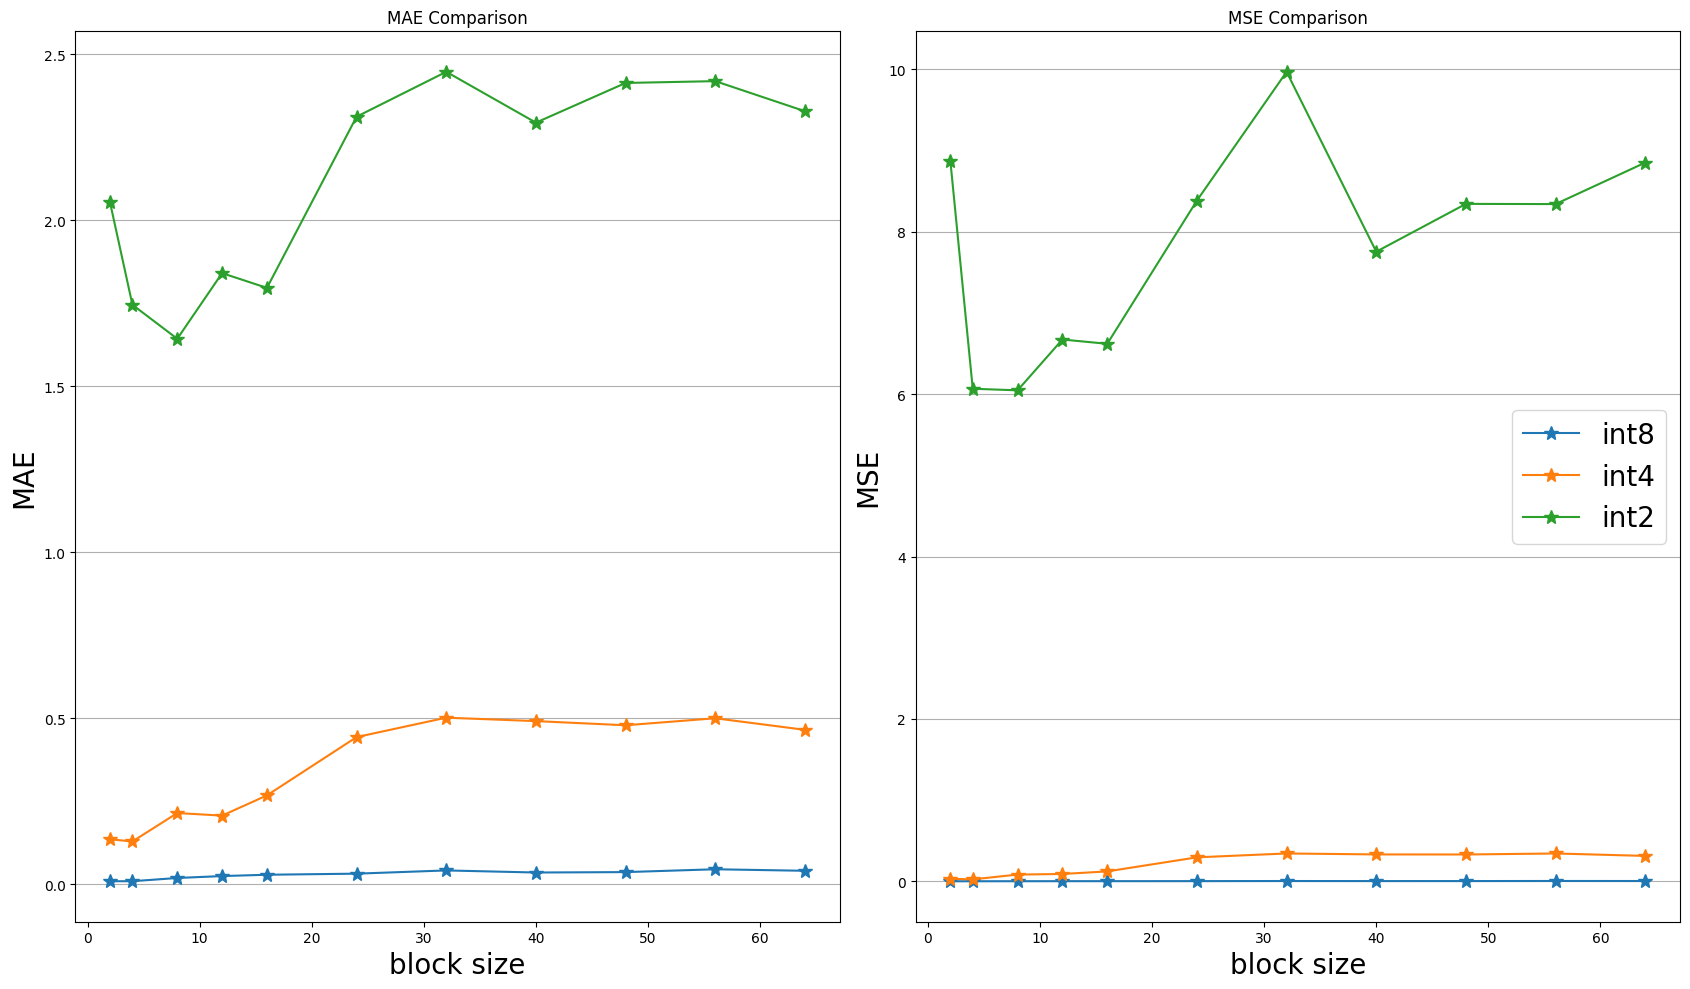

In [57]:
# Visualize the metrics
plt.figure(figsize=(17, 10))
quant_list = ['int8', 'int4', 'int2']
blocksize_list = [2,4,8,12,16,24,32,40,48,56,64]
for quant_method in quant_list:
  mae_list=[]
  mse_list=[]
  for blocksize in blocksize_list:
    mxint_specs=MxSpecs()
    mxint_specs['w_elem_format'] = quant_method
    mxint_specs['a_elem_format'] = quant_method
    mxint_specs['block_size'] = blocksize
    mxint_specs['shared_exp_method'] = 'max'

    mxint_result = matmul_accumulate(A_torch, B_torch, C_torch, mx_specs=mxint_specs)
    mae_list.append(torch.mean(torch.abs(mxint_result - D_torch)))
    mse_list.append(torch.mean((mxint_result - D_torch) ** 2))

    print(f"mx_{quant_method} blocksize {blocksize}")
    mae = torch.mean(torch.abs(mxint_result - D_torch)).item()
    mse = torch.mean((mxint_result - D_torch) ** 2).item()
    print(f"MAE: {mae:.4f}")
    print(f"MSE: {mse:.4f}\n")

    _, mxint_predicted = torch.max(mxint_result.data, 1)
    # print(f"mx{quant_method} blocksize: {blocksize}, Truth Label: {labels}, Predicted: {mxint_predicted}")
    # print(f"mx{quant_method}_result:\n", mxint_result)
    print("\n")

  # MAE
  plt.subplot(1,2,1)
  plt.plot(blocksize_list,mae_list,markersize=10, marker='*', label=quant_method)
  plt.xlabel('block size', size=20)
  plt.ylabel('MAE', size=20)
  plt.title('MAE Comparison')
  plt.grid(axis='y')

  plt.subplot(1,2,2)
  plt.plot(blocksize_list,mse_list,markersize=10, marker='*', label=quant_method)
  plt.xlabel('block size', size=20)
  plt.ylabel('MSE', size=20)
  plt.title('MSE Comparison')
  plt.grid(axis='y')

plt.legend(fontsize=20)
plt.tight_layout()
plt.show()

### Test mx_fp quantization mx_(fp8_e5m2, fp8_e4m3, fp6_e3m2, fp6_e2m3, fp4_e2m1,  fp16, bf16) for various block sizes
   
Plot and analyze how error trends vary with block size

mx_fp8_e5m2 blocksize 4
MAE: 2.3288779258728027
MSE: 8.852150917053223



mx_fp8_e5m2 blocksize 8
MAE: 2.3288779258728027
MSE: 8.852150917053223



mx_fp8_e5m2 blocksize 16
MAE: 2.3288779258728027
MSE: 8.852150917053223



mx_fp8_e5m2 blocksize 24
MAE: 2.3288779258728027
MSE: 8.852150917053223



mx_fp8_e5m2 blocksize 32
MAE: 2.3288779258728027
MSE: 8.852150917053223



mx_fp8_e5m2 blocksize 40
MAE: 2.3288779258728027
MSE: 8.852150917053223



mx_fp8_e5m2 blocksize 48
MAE: 2.3288779258728027
MSE: 8.852150917053223



mx_fp8_e5m2 blocksize 56
MAE: 2.3288779258728027
MSE: 8.852150917053223



mx_fp8_e5m2 blocksize 64
MAE: 2.3288779258728027
MSE: 8.852150917053223



mx_fp8_e4m3 blocksize 4
MAE: 2.3288779258728027
MSE: 8.852150917053223



mx_fp8_e4m3 blocksize 8
MAE: 2.3288779258728027
MSE: 8.852150917053223



mx_fp8_e4m3 blocksize 16
MAE: 2.3288779258728027
MSE: 8.852150917053223



mx_fp8_e4m3 blocksize 24
MAE: 2.3288779258728027
MSE: 8.852150917053223



mx_fp8_e4m3 blocksize 32
MAE:

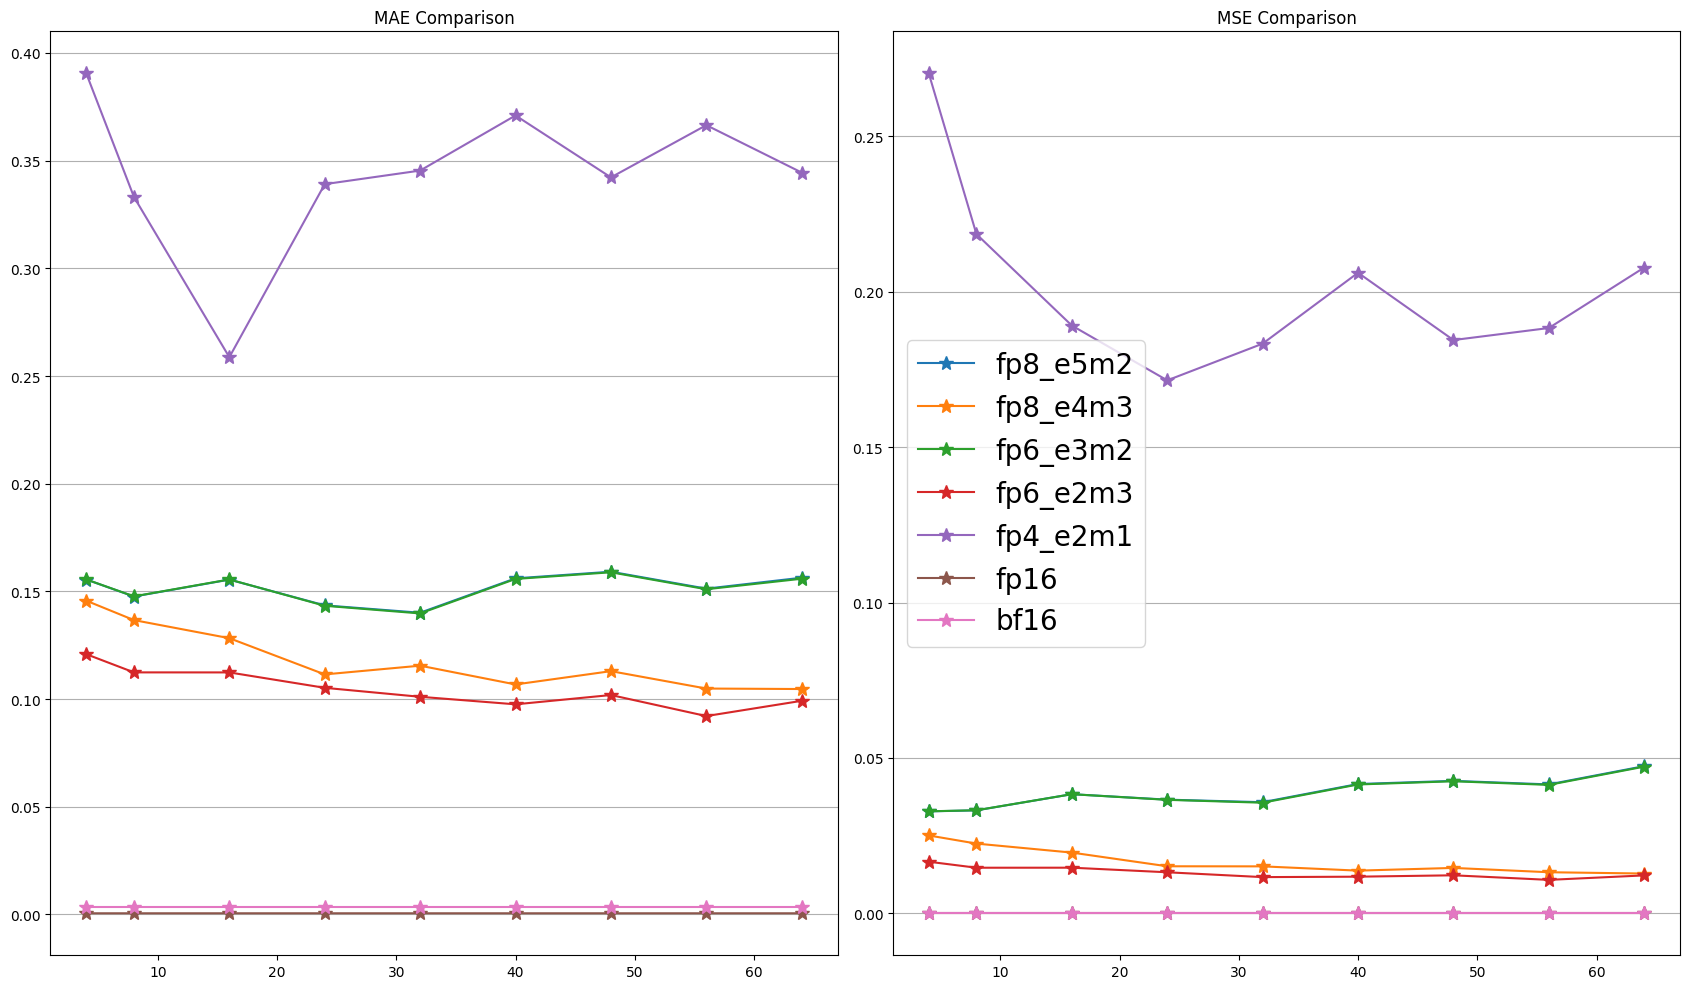

In [58]:
# Visualize the metrics
plt.figure(figsize=(17, 10))
quant_list = ['fp8_e5m2', 'fp8_e4m3', 'fp6_e3m2', 'fp6_e2m3', 'fp4_e2m1',  'fp16', 'bf16']

blocksize_list = [4, 8,16,24,32,40,48,56,64,]
for quant_method in quant_list:
  mae_list=[]
  mse_list=[]
  for blocksize in blocksize_list:
    mxfp_specs=MxSpecs()
    mxfp_specs['scale_bits']=8
    mxfp_specs['w_elem_format'] = quant_method
    mxfp_specs['a_elem_format'] = quant_method
    mxfp_specs['block_size'] = blocksize
    mxfp_specs['shared_exp_method'] = 'max'
    mxfp_specs = finalize_mx_specs(mxfp_specs)

    mxfp_result = matmul_accumulate(A_torch, B_torch, C_torch, mx_specs=mxfp_specs)
    mae_list.append(torch.mean(torch.abs(mxfp_result - D_torch)))
    mse_list.append(torch.mean((mxfp_result - D_torch) ** 2))

    print(f"mx_{quant_method} blocksize {blocksize}")
    print(f"MAE: {torch.mean(torch.abs(mxint_result - D_torch))}")
    print(f"MSE: {torch.mean((mxint_result - D_torch) ** 2)}\n")

    _, mxfp_predicted = torch.max(mxfp_result.data, 1)
    # print(f"mx{quant_method} blocksize: {blocksize}, Truth Label: {labels}, Predicted: {mxfp_predicted}")
    # print(f"mx{quant_method}_result:\n", mxfp_result)
    print("\n")

  # MAE
  plt.subplot(1,2,1)
  plt.plot(blocksize_list,mae_list,markersize=10, marker='*', label=quant_method)
  plt.title('MAE Comparison')
  plt.grid(axis='y')

  plt.subplot(1,2,2)
  plt.plot(blocksize_list,mse_list,markersize=10, marker='*', label=quant_method)
  plt.title('MSE Comparison')
  plt.grid(axis='y')

# plt.grid(axis='y')
plt.legend(fontsize=20)
plt.tight_layout()
plt.show()

### Evaluate quantized DNN with different MX data formats.


Original Test Accuracy: 0.91
quant method:mxint8, blocksize: 16, accuracy: 0.9144
quant method:mxint4, blocksize: 16, accuracy: 0.9134
quant method:mxint2, blocksize: 16, accuracy: 0.8474
quant method:mxfp8_e5m2, blocksize: 16, accuracy: 0.9137
quant method:mxfp8_e4m3, blocksize: 16, accuracy: 0.9155
quant method:mxfp6_e3m2, blocksize: 16, accuracy: 0.9137
quant method:mxfp6_e2m3, blocksize: 16, accuracy: 0.9158
quant method:mxfp4_e2m1, blocksize: 16, accuracy: 0.915
quant method:mxfp16, blocksize: 16, accuracy: 0.9147
quant method:mxbf16, blocksize: 16, accuracy: 0.9148
quant method:mxint8, blocksize: 32, accuracy: 0.9147
quant method:mxint4, blocksize: 32, accuracy: 0.9129
quant method:mxint2, blocksize: 32, accuracy: 0.7499
quant method:mxfp8_e5m2, blocksize: 32, accuracy: 0.9138
quant method:mxfp8_e4m3, blocksize: 32, accuracy: 0.9162
quant method:mxfp6_e3m2, blocksize: 32, accuracy: 0.9139
quant method:mxfp6_e2m3, blocksize: 32, accuracy: 0.9159
quant method:mxfp4_e2m1, blocksize:

<ipython-input-59-b49cf6bc44eb>:85: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


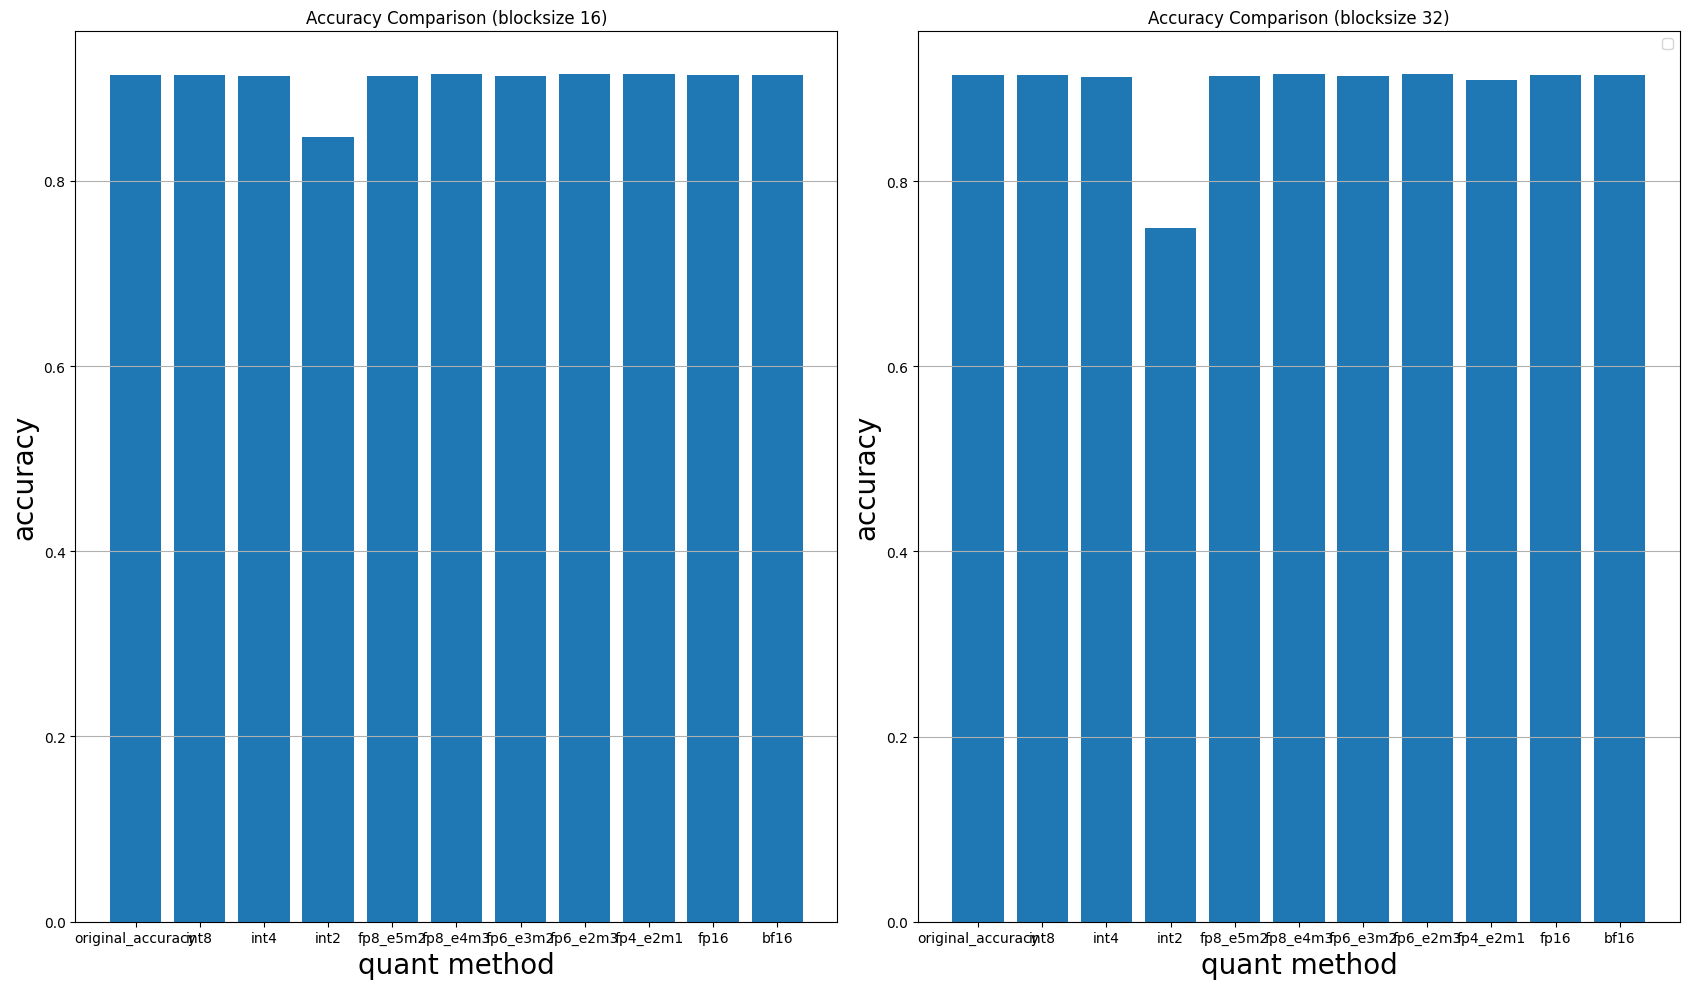

In [59]:
# Evaluate the model
def test_model():
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    print(f"Original Test Accuracy: {accuracy:.2f}")
    return accuracy


def test_model_mx(mx_specs):
  model.eval()
  correct = 0
  total = 0
  with torch.no_grad():
      for i, (images, labels) in enumerate(test_loader):
        images, labels = images.to(device), labels.to(device)

        # Flatten images for torch.nn.functional.linear
        images_flat = images.view(-1, 28*28)  # Shape: (1, 784)

        # Compute output using torch.nn.functional.linear
        # outputs = torch.nn.functional.linear(input=images_flat, weight=weight_matrix, bias=bias_vector)
        outputs = mx.linear(images_flat, B_torch, C_torch, mx_specs=mx_specs)
        # Get predicted class
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
  accuracy = correct / total
  # print(f"Test Accuracy: {accuracy:.2f}%")
  return accuracy

# Re-evaluate model accuracy using original (full-precision) weights
# This is the baseline for assessing quantized inference accuracy
original_accuracy = test_model()

# Visualize the metrics
plt.figure(figsize=(17, 10))

quant_list = ['int8', 'int4', 'int2','fp8_e5m2', 'fp8_e4m3', 'fp6_e3m2', 'fp6_e2m3', 'fp4_e2m1',  'fp16', 'bf16']
blocksize_list = [16,32,]

# Define test_model_mx: inference with quantized formats using microxcaling
# Used to simulate low-bit inference performance
for blocksize in blocksize_list:
  accuracy_list=[]
  for quant_method in quant_list:
    mxint_specs=MxSpecs()
    mxint_specs['w_elem_format'] = quant_method
    mxint_specs['a_elem_format'] = quant_method
    mxint_specs['block_size'] = blocksize
    mxint_specs['shared_exp_method'] = 'max'
    accuracy = test_model_mx(mxint_specs)
    accuracy_list.append(accuracy)
    print(f"quant method:mx{quant_method}, blocksize: {blocksize}, accuracy: {accuracy}")

  if blocksize == 16:
    plt.subplot(1,2,1)
    plt.bar(['original_accuracy']+quant_list, [original_accuracy] + accuracy_list, )
    plt.xlabel('quant method', size=20)
    plt.ylabel('accuracy', size=20)
    plt.title(f'Accuracy Comparison (blocksize {blocksize})')
    plt.grid(axis='y')
    # plt.ylim(0.84,1)

  if blocksize == 32:
    plt.subplot(1,2,2)
    plt.bar(['original_accuracy']+quant_list, [original_accuracy] + accuracy_list, )
    plt.xlabel('quant method', size=20)
    plt.ylabel('accuracy', size=20)
    plt.title(f'Accuracy Comparison (blocksize {blocksize})')
    plt.grid(axis='y')
    # plt.ylim(0.7,1)

plt.legend()

plt.tight_layout()
plt.show()